In [1]:
import gmesh_conv.meshing
import numpy as np
import Fields.Fields as fields
import Kernels.Kernels as kernels


In [2]:
# Get the gmsh mesh as a mesh object
mesh = gmesh_conv.meshing.mesh_from_gmsh('gmesh_conv/test.msh')

Info    : Reading 'gmesh_conv/test.msh'...
Info    : 27 entities
Info    : 313 nodes
Info    : 1603 elements
Info    : Done reading 'gmesh_conv/test.msh'
Total volume is: 0.9999999999999997
Information for mesh with id of 0
Volume information:
	Volume ID 0  Physical Name: controlVolume
Surface information:
	Surface ID 0  Physical Name: zPlus
	Surface ID 1  Physical Name: xPlus
	Surface ID 2  Physical Name: yPlus
	Surface ID 3  Physical Name: xMinus
	Surface ID 4  Physical Name: yMinus
	Surface ID 5  Physical Name: zMinus


In [3]:
# write a variable with all the volume ids of interest.
wholeProblem = [mesh.volumes[0]]  # there is only one volume and it has id of 0

In [4]:
# make a pure zero field to describe the initial conditions or initial guess of the problem.
# we use the wholeProblem before as the volume list since it is a list of volumes that contains all the elements that the field lives on.
# wholeProblem
#   volumes in the wholeProble list from above
#     elements in this volume
#       element id for this element
zeroField = fields.ZeroScalarField(volumeList=wholeProblem, m=mesh)

In [5]:
# now make a scalar field - we will call this T
# use the initial condition zeroField to set the IC of the ScalarField
C = fields.ScalarField(initial_condition=zeroField, name='C')



In [6]:
# now add a diffusion kernel to the field
diffKernel = kernels.DiffusionKernel(Gamma=1, field=C, volumeList = wholeProblem, orthogonalityApproach='MCA', m=mesh)

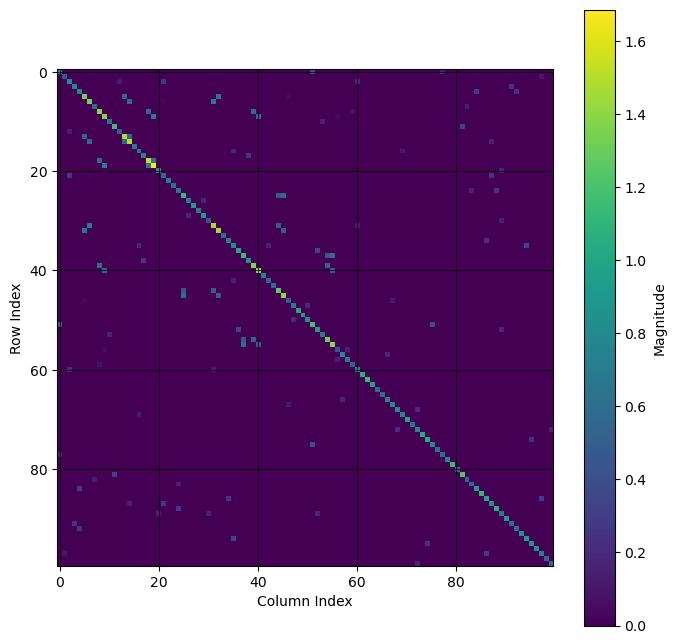

In [9]:
diffKernel.plot_coeffs(coeff_range=100)